In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import os
import os.path as osp

In [4]:
income_file = '../../../ddf--gapminder--fasttrack/ddf--datapoints--mincpcap_cppp--by--country--time.csv'
gini_file =  '../../../ddf--gapminder--fasttrack/ddf--datapoints--gini--by--country--time.csv'
shapes_file = '../wip/smoothshape/ddf--datapoints--population_percentage--by--country--year--coverage_type--bracket.csv'

In [5]:
income = pd.read_csv(income_file).set_index(['country', 'time'])
gini = pd.read_csv(gini_file).set_index(['country', 'time'])
shapes = pd.read_csv(shapes_file)

In [6]:
# convert xkx to kos. Same country, but povcal and open-numbers use different code
shapes['country'] = shapes['country'].replace({'xkx': 'kos'})

In [7]:
merge = pd.concat([income, gini], axis=1)

In [8]:
merge

mincpcap_cppp  gini
country time                     
afg     1800         0.9194  30.5
        1801         0.9194  30.5
        1802         0.9194  30.5
        1803         0.9194  30.5
        1804         0.9194  30.5
...                     ...   ...
zwe     2046         5.5473   NaN
        2047         5.6645   NaN
        2048         5.7845   NaN
        2049         5.9075   NaN
        2050         6.0332   NaN

[49427 rows x 2 columns]

In [9]:
# get all available country/year pair from povcal

unique_country_year = shapes[['country', 'year']].drop_duplicates()

In [10]:
known_income = list()
known_gini = list()

for _, row in unique_country_year.iterrows():
    r = (row['country'], row['year'])
    if r in merge.index:
        i = merge.loc[r, 'mincpcap_cppp']
        g = merge.loc[r, 'gini']
    else:
        i = np.nan
        g = np.nan
    known_income.append(i)
    known_gini.append(g)

In [11]:
idx = pd.MultiIndex.from_frame(unique_country_year)
known_country_year_df = pd.DataFrame({'income': known_income, 'gini': known_gini}, index=idx)

In [12]:
known_country_year_df

income  gini
country year              
ago     1981  5.5461  53.8
        1982  5.3525  53.7
        1983  5.3818  53.6
        1984  5.5050  53.5
        1985  5.4991  53.4
...              ...   ...
zwe     2015  4.4835  43.2
        2016  4.1485  43.2
        2017  3.9717  43.2
        2018  4.2896  43.2
        2019  4.0536  43.2

[6409 rows x 2 columns]

In [13]:
known_country_year_df.to_csv('../wip/income_gini_for_known_shape_countries.csv')

In [14]:
np.log(1)

0.0

In [15]:
def get_distances(income, gini):
    # get country/year pair which is close to the input income gini.
    # note: result country will not be duplicated. because one country don't change
    # often enough for a few years, so we avoid having dulicated country and nearby years
    res = np.sqrt(np.power(np.log(known_country_year_df['income']) - np.log(income), 2) + 
                  np.power(known_country_year_df['gini'] - gini, 2))
    return res.sort_values(ascending=True)

In [16]:
# TODO: add get_distance by rectangle

In [105]:
def get_neighbors_n_countries(income, gini, n=5, radius=5, only_once=False):
    neis = list()
    ecs = set()
    res = get_distances(income, gini)
    res = res[(res < radius)]
    for i, v in res.iteritems():
        if only_once and i[0] in ecs:
            continue
        ecs.add(i[0])
        neis.append(i)
        if len(ecs) >= n:
            break
    if len(ecs) < n:
        print(f'can not get enough countries, only {len(ecs)} countries selected')
    return neis

In [18]:
def get_neighbors(income, gini, n=10, radius=5):
    """
    """
    neis = list()
    res = get_distances(income, gini)
    res = res[(res < radius)]
    for i, v in res.iteritems():
        neis.append(i)
        if len(neis) >= n:
            break
    if len(neis) < n:
        print(f'can not get enough points, only {len(neis)} points selected')
    return neis

In [21]:
get_neighbors(2, 40, 20)

[('uga', 1996),
 ('ben', 1995),
 ('tcd', 2002),
 ('nga', 1987),
 ('tcd', 2003),
 ('ben', 1996),
 ('sle', 2003),
 ('uga', 1997),
 ('uga', 1995),
 ('tcd', 2001),
 ('ben', 1994),
 ('gin', 2006),
 ('mli', 2003),
 ('eth', 1997),
 ('ner', 2007),
 ('tkm', 1997),
 ('mdg', 1998),
 ('sle', 2004),
 ('tza', 2007),
 ('ben', 2006)]

In [22]:
# making a plot for available gini/income pair and all gini/income pair

In [23]:
merge_ = merge.dropna(how='any')

In [24]:
def do_plot():
    ax = plt.subplot(1, 1, 1)
    ax.scatter(known_country_year_df['income'], known_country_year_df['gini'], s=1, color='#AA00FF')
    ax.scatter(merge_['mincpcap_cppp'], merge_['gini'], s=1, alpha=.1, color='grey')
    ax.set_xscale('log')
    ax.set_xlabel('income')
    ax.set_ylabel('gini')
    return ax

In [25]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['figure.dpi'] = 196

<AxesSubplot:xlabel='income', ylabel='gini'>

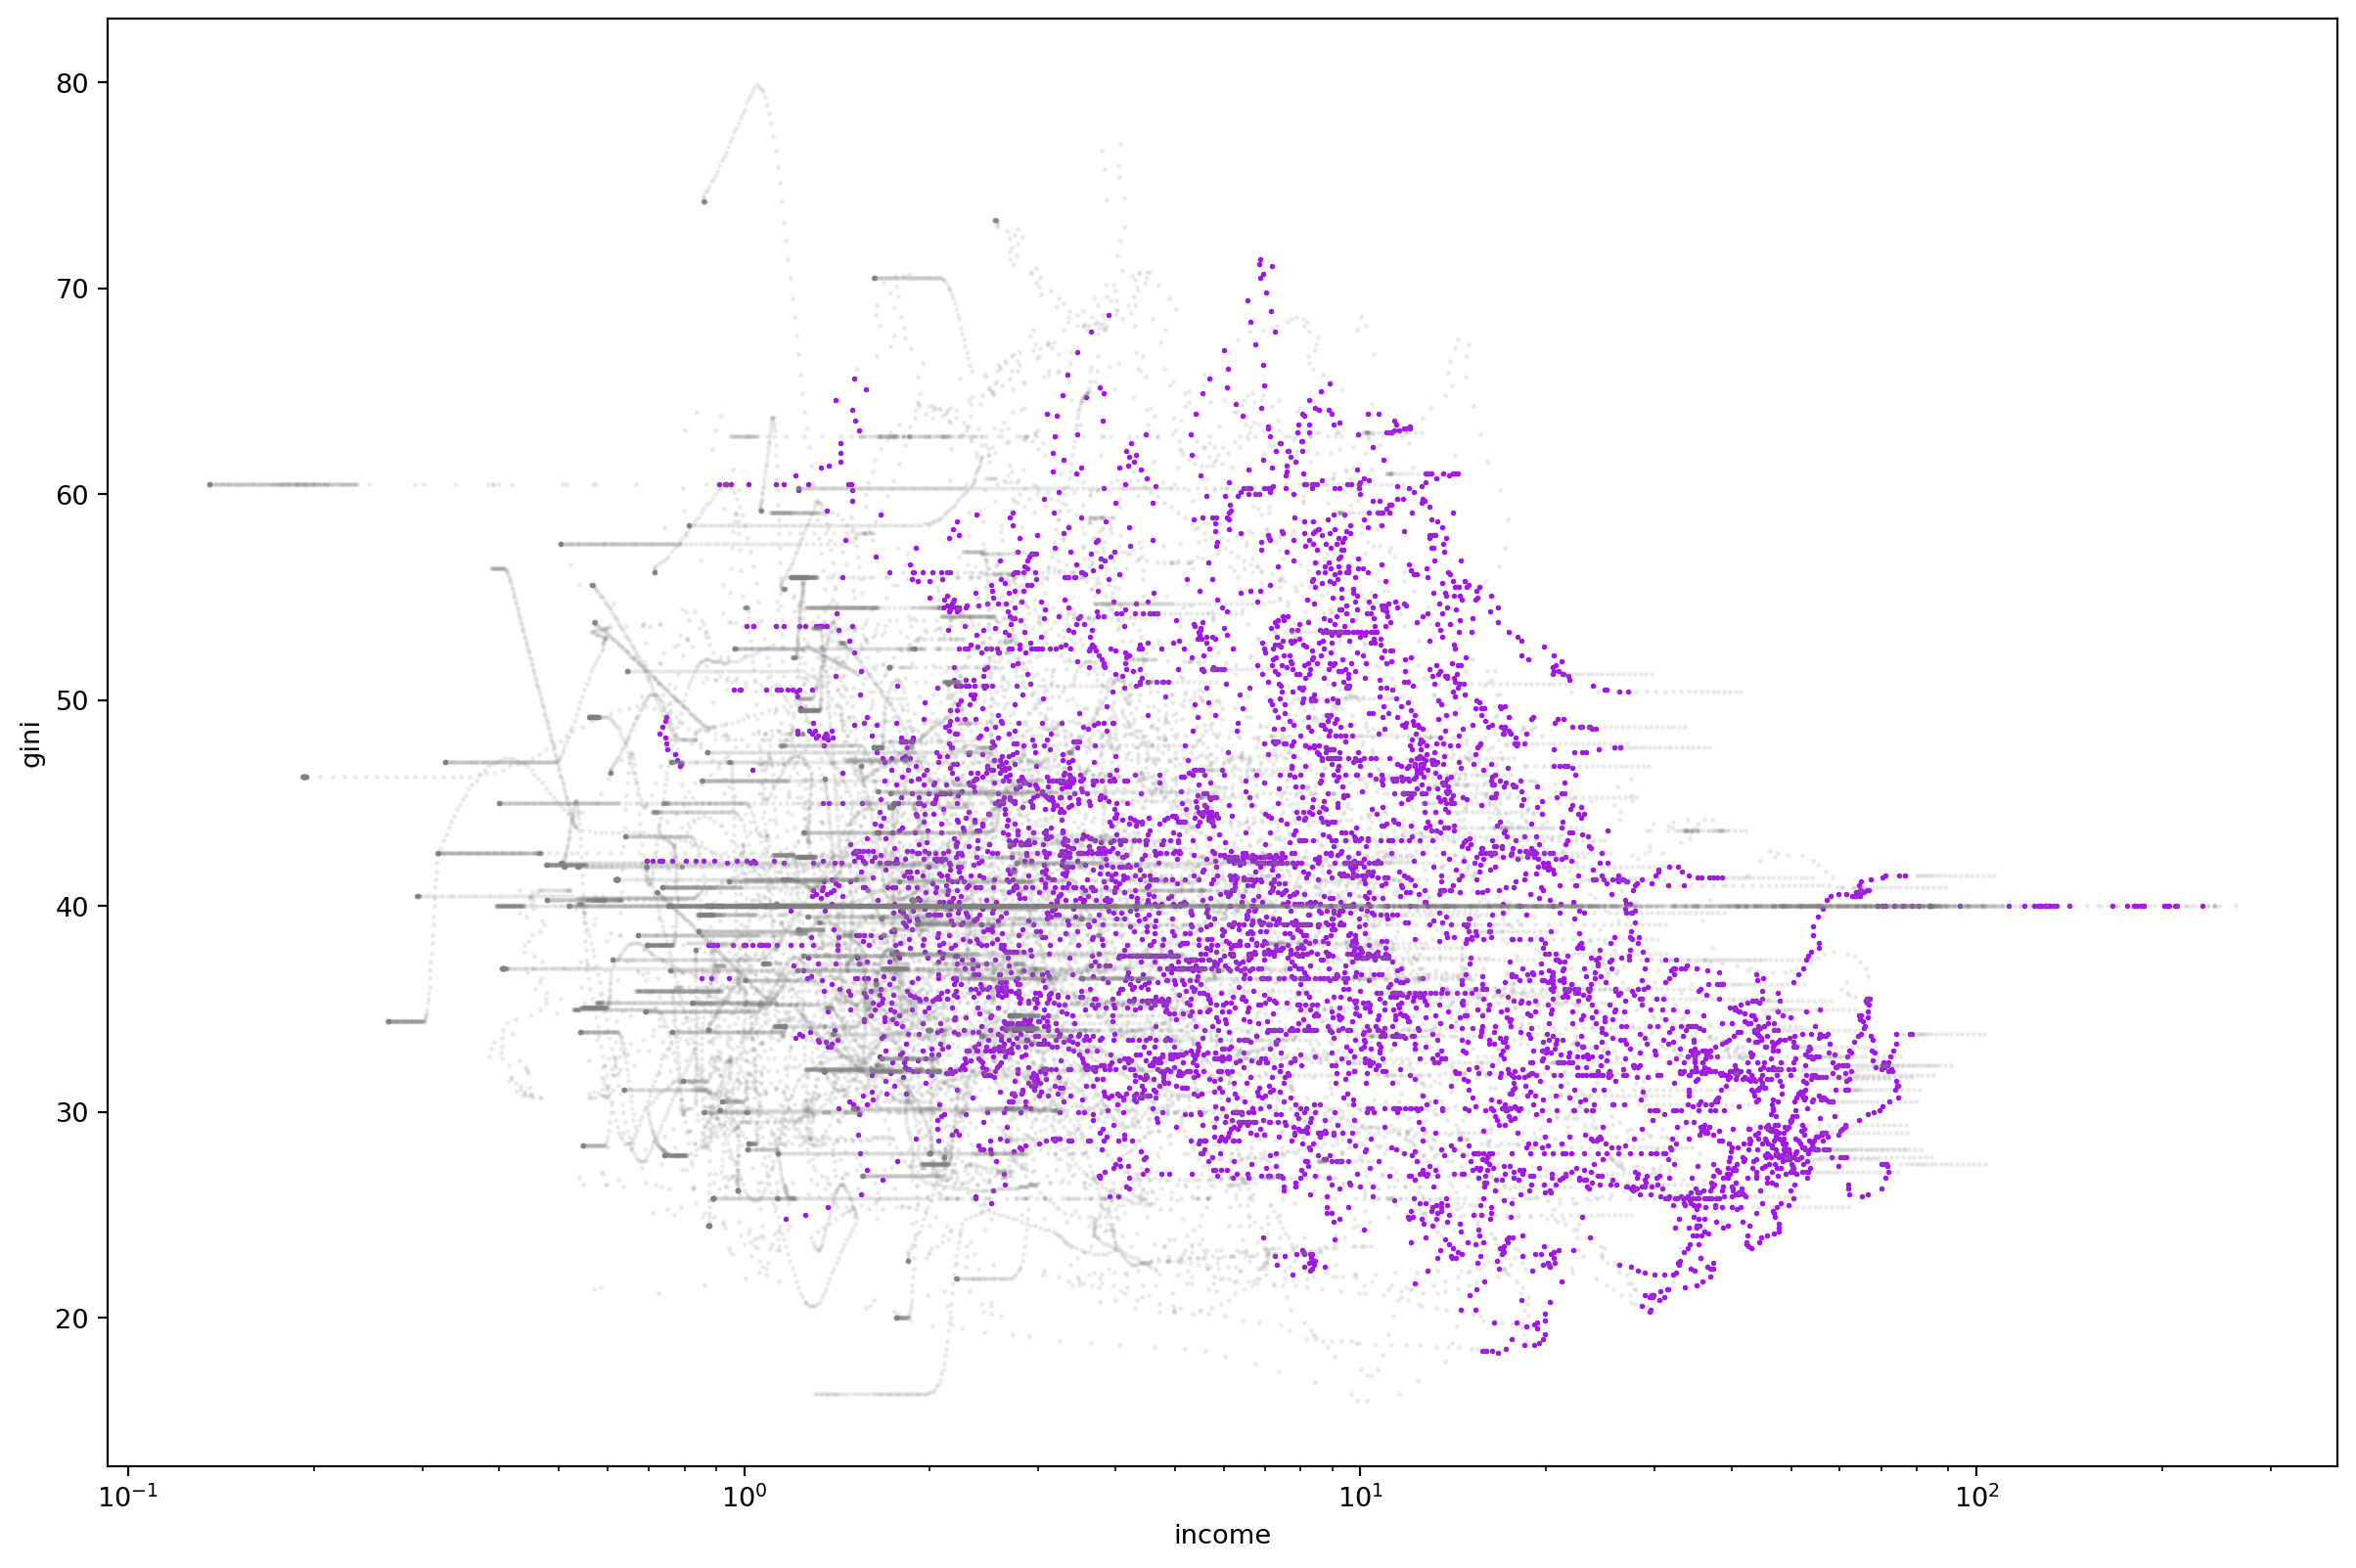

In [26]:
do_plot()

In [27]:
# next, merging shapes and calculate mean

In [28]:
from functools import reduce

In [29]:
def merge_2shapes(s1, s2):
    s1_, s2_ = s1.align(s2, fill_value=0)
    s3 = (s1_ + s2_) / 2
    return s3

In [30]:
# this is wrong, don't do this
# def merge_nshapes(s_list):
#     return reduce(merge_2shapes, s_list)

In [31]:
def merge_nshapes(s_list):
    n = len(s_list)
    res = pd.concat(s_list, axis=1).fillna(0)
    return res.mean(axis=1)

In [32]:
shapes

,country,year,coverage_type,bracket,population_percentage
0,ago,1981,n,-94,0.000015
1,ago,1981,n,-93,0.000018
2,ago,1981,n,-92,0.000021
3,ago,1981,n,-91,0.000024
4,ago,1981,n,-90,0.000028
...,...,...,...,...,...
1321156,zwe,2019,n,105,0.000001
1321157,zwe,2019,n,106,0.000001
1321158,zwe,2019,n,107,0.000000
1321159,zwe,2019,n,108,0.000000


In [33]:
shapes_ = shapes.set_index(['country', 'year']).sort_index()

In [34]:
def get_shape(idx):
    df = shapes_.loc[idx]
    for t in 'naur':
        if t in df['coverage_type'].values:
            if t in 'ur':
                print('using urban/rural data')
            df_nc = df[df['coverage_type'] == t]
            df_nc = df_nc.set_index('bracket')['population_percentage']
            return df_nc

In [35]:
get_shape(('chn', 1981))

bracket
-71     0.000002
-70     0.000002
-69     0.000002
-68     0.000003
-67     0.000003
          ...   
 123    0.000000
 124    0.000000
 125    0.000000
 126    0.000000
 127    0.000000
Name: population_percentage, Length: 199, dtype: float64

In [36]:
slist = get_neighbors(6, 50)

In [37]:
df_list = list(map(get_shape, slist))

In [38]:
res = merge_nshapes(df_list)

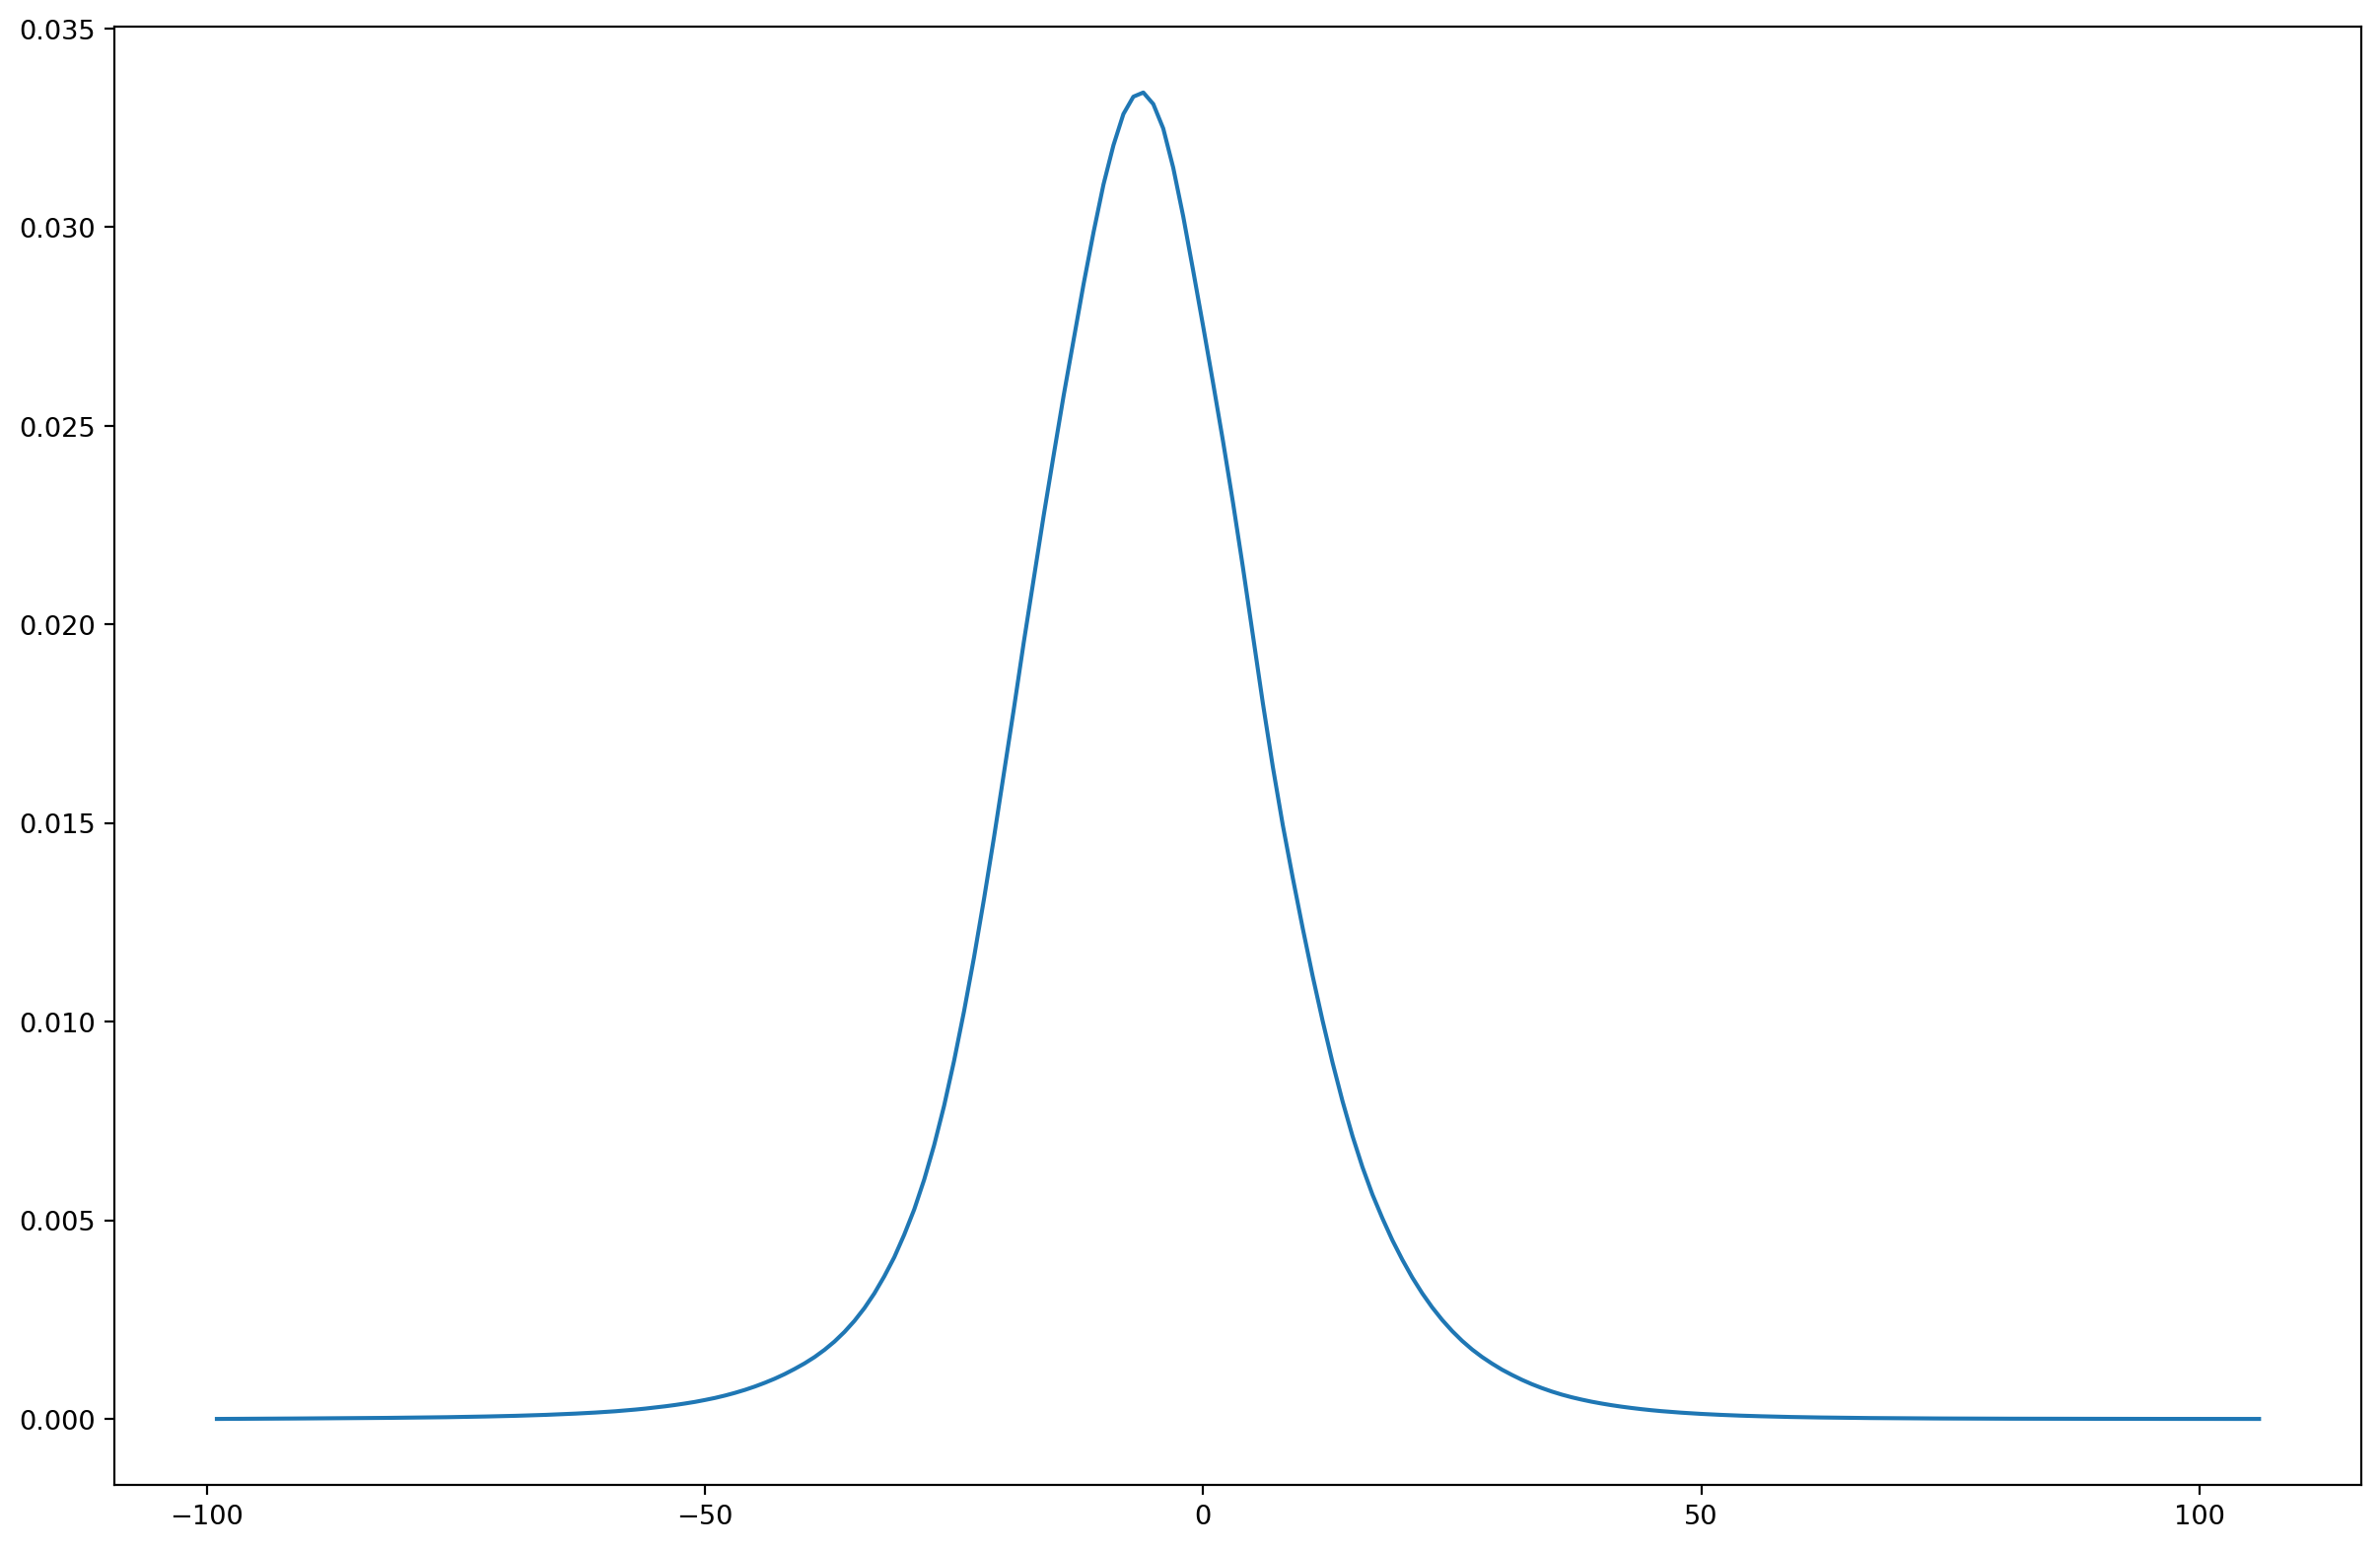

In [39]:
plt.plot(res)

In [40]:
def bracket_number_from_income(s):
    return ((np.log2(s / 30) + 7) / delta).astype(int)

In [41]:
def get_income_gini(idx):
    i = merge.loc[idx, 'mincpcap_cppp']
    g = merge.loc[idx, 'gini']
    return i, g

In [42]:
def get_estimated_shape(idx, neighbours=5):
    # 1. if the idx is in known shapes, just return the known shape
    # 2. if not, return the estimated shape
    if idx in shapes_.index:
        return get_shape(idx)
    else:
        i, g = get_income_gini(idx)
        nei = get_neighbors(i, g, neighbours_n)
        slist = list(map(get_shape, nei))
        return merge_nshapes(slist)

In [43]:
def get_estimated_shape_2(income, gini, neighbours=5):
    # get estimated shape based on income and gini
    nei = get_neighbors(income, gini, neighbours+1)
    slist = list(map(get_shape, nei[1:]))
    return merge_nshapes(slist)

In [108]:
def get_estimated_shape_3(income, gini, neighbours=5):
    # get estimated shape based on income and gini
    nei = get_neighbors_n_countries(income, gini, neighbours+1)
    slist = list(map(get_shape, nei[1:]))
    return merge_nshapes(slist)

In [128]:
def get_estimated_shape_4(income, gini, neighbours=10):
    # get estimated shape based on income and gini
    nei = get_neighbors_n_countries(income, gini, neighbours+1, only_once=True)
    print(nei)
    slist = list(map(get_shape, nei[1:]))
    return merge_nshapes(slist)

In [129]:
# x = ('geo', 1990) is outliner, can be checked later
x = ('usa', 2000)
i, g = get_income_gini(x)
res1 = get_estimated_shape_4(i, g, 10)
res2 = get_shape(x)

[('usa', 2000), ('are', 2015), ('mys', 2019), ('isr', 2003), ('ury', 2013), ('rus', 2012), ('tto', 2006), ('arg', 1981), ('lbn', 1985), ('srb', 1990), ('tur', 2013)]
using urban/rural data


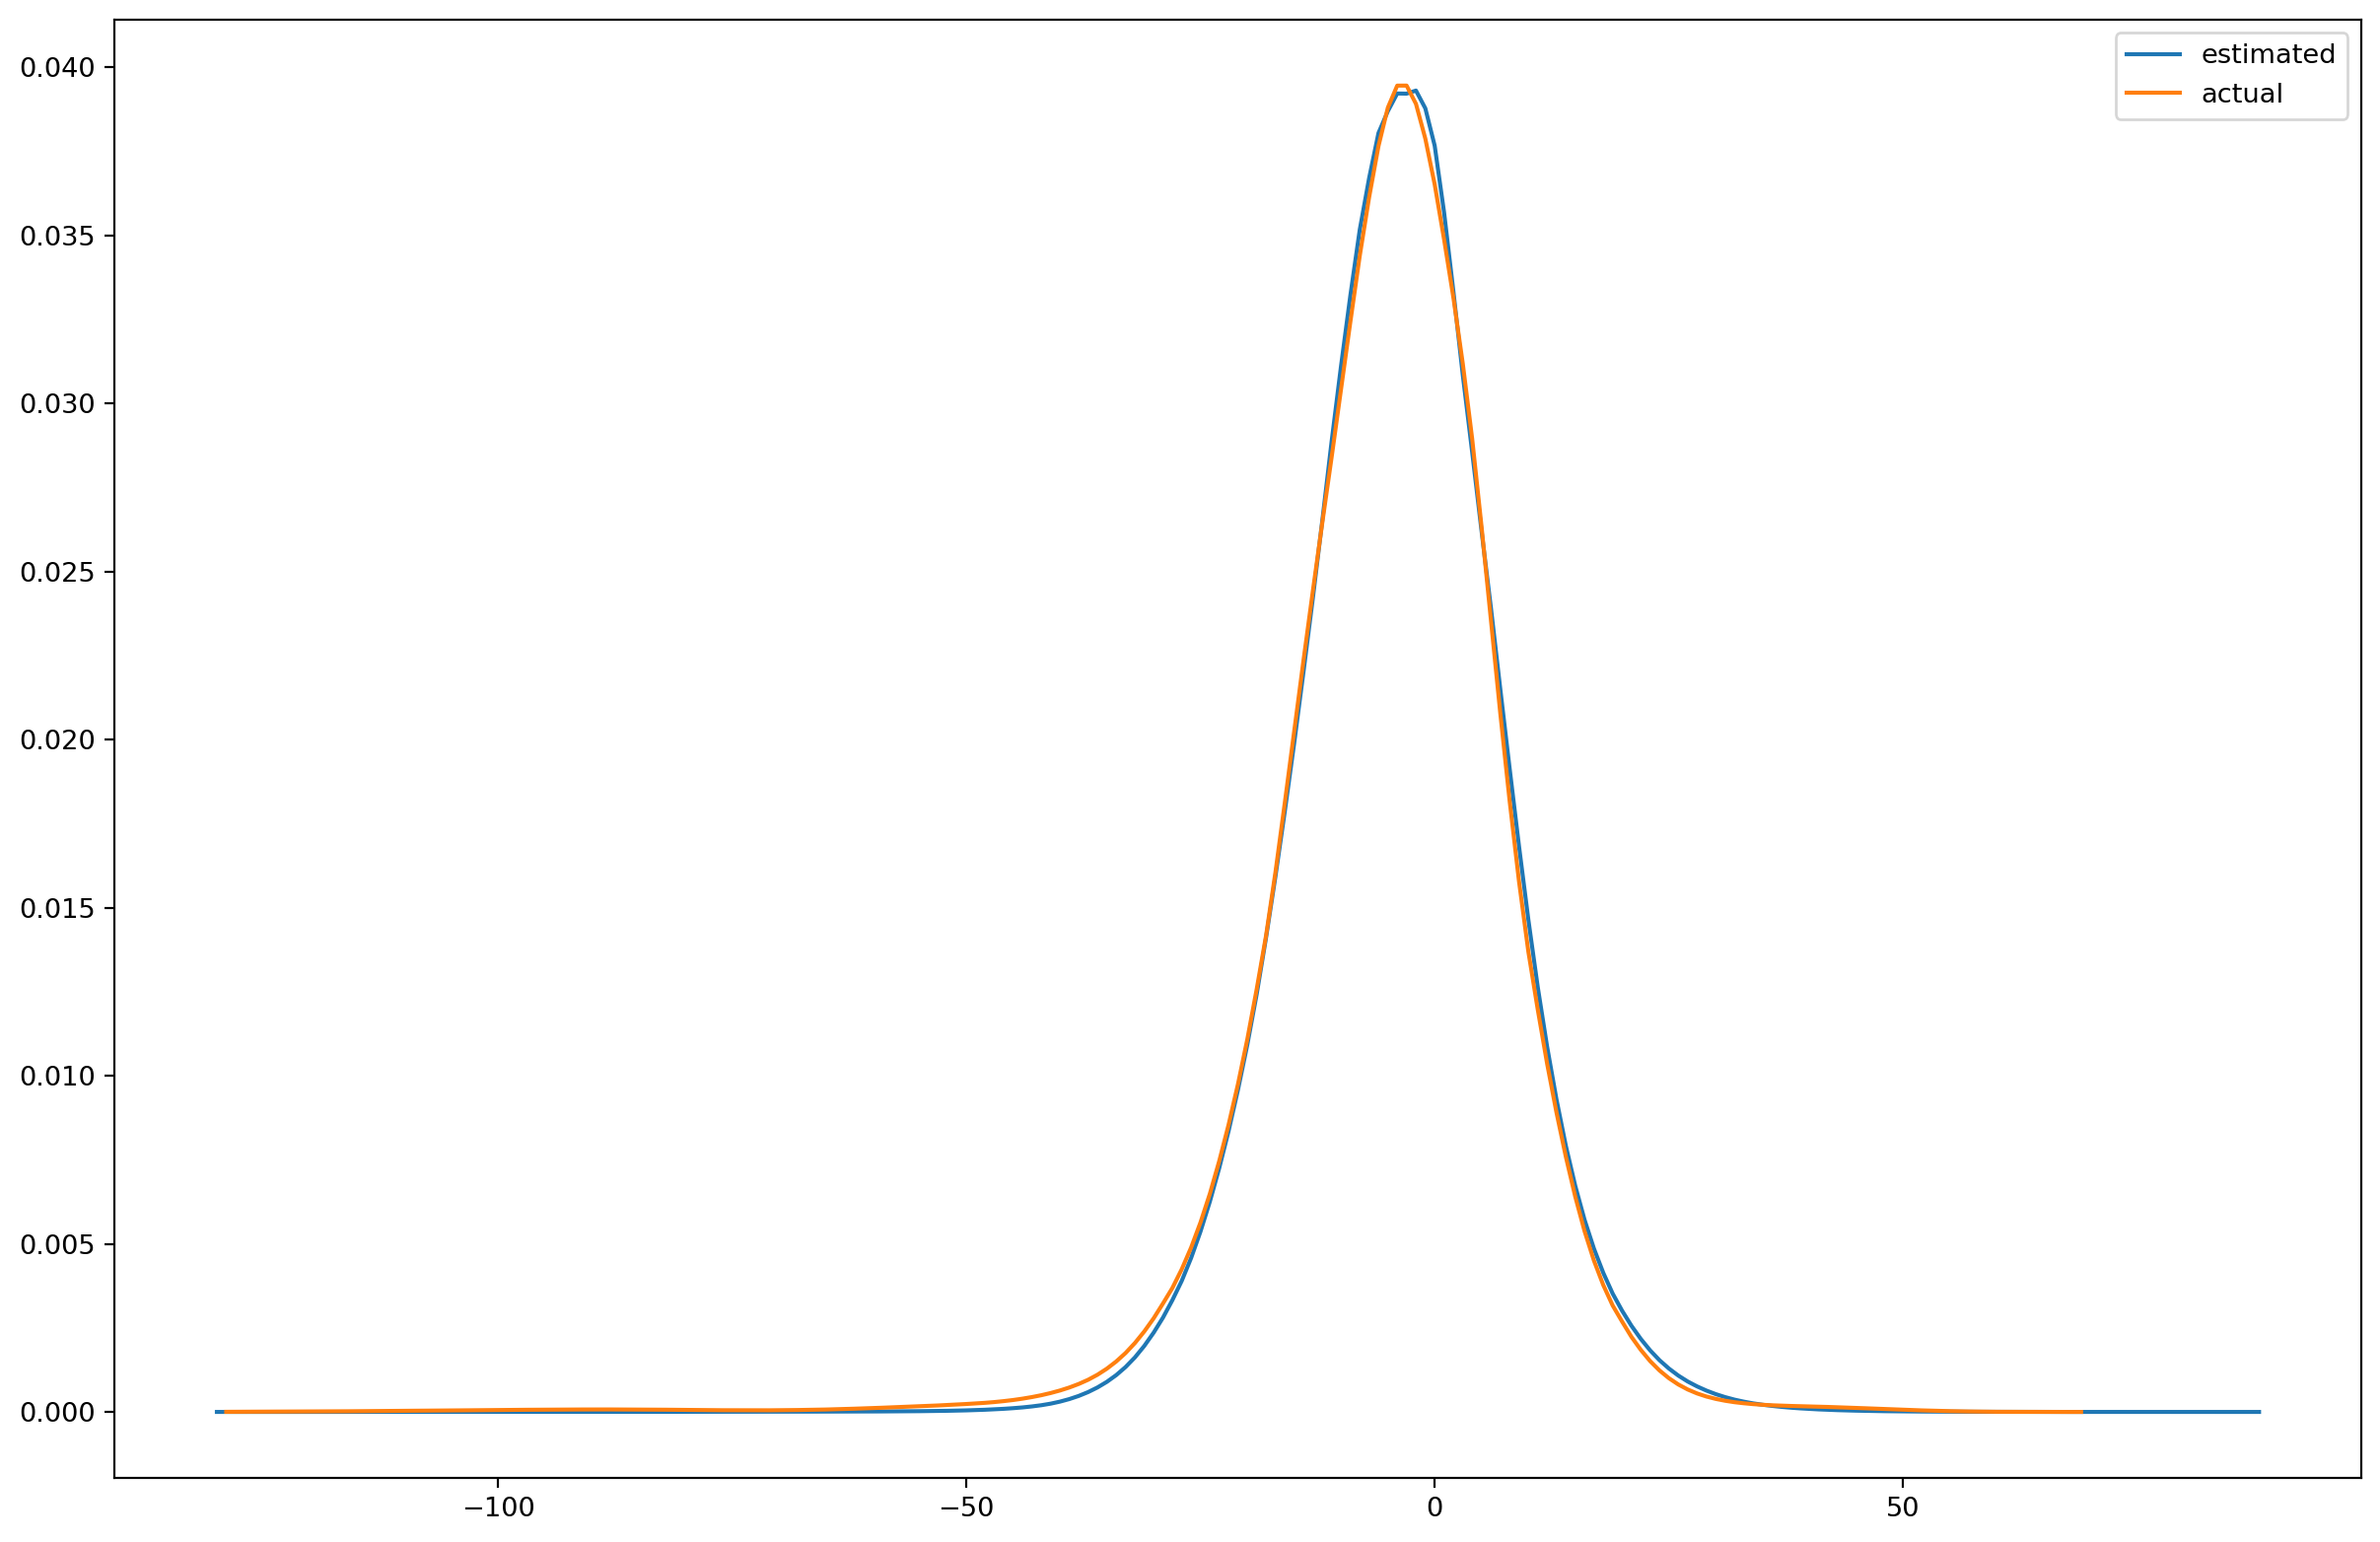

In [127]:
plt.plot(res1, label='estimated')
plt.plot(res2, label='actual')
plt.legend()

In [45]:
s0 = get_shape(('bra', 1990))
nei_ = [('pan', 1990),
       ('bwa', 1996),
       ('nam', 2014)
      ]
nei = [('sur', 1998), ('col', 2000), ('chl', 1984)]
slist = list(map(get_shape, nei_))
s3 = merge_nshapes(slist)

In [46]:
# income/gini for some point
get_income_gini(('bra', 1990))

(9.4026, 59.0)

In [47]:
# neighbours with least distances
nei = [('sur', 1998), 
       ('col', 2000), 
       ('chl', 1984)]

for n in nei:
    print(get_income_gini(n))

(9.3744, 57.3)
(9.3369, 57.7)
(9.4693, 56.2)


In [48]:
# my hand pick neighbours
nei = [('pan', 1990),
       ('bwa', 1996),
       ('nam', 2014)
      ]

for n in nei:
    print(get_income_gini(n))

(8.5557, 58.3)
(6.9548, 61.7)
(10.7485, 59.7)


In [50]:
def do_plot_compare_mountains(s0, neighbours):
    pass

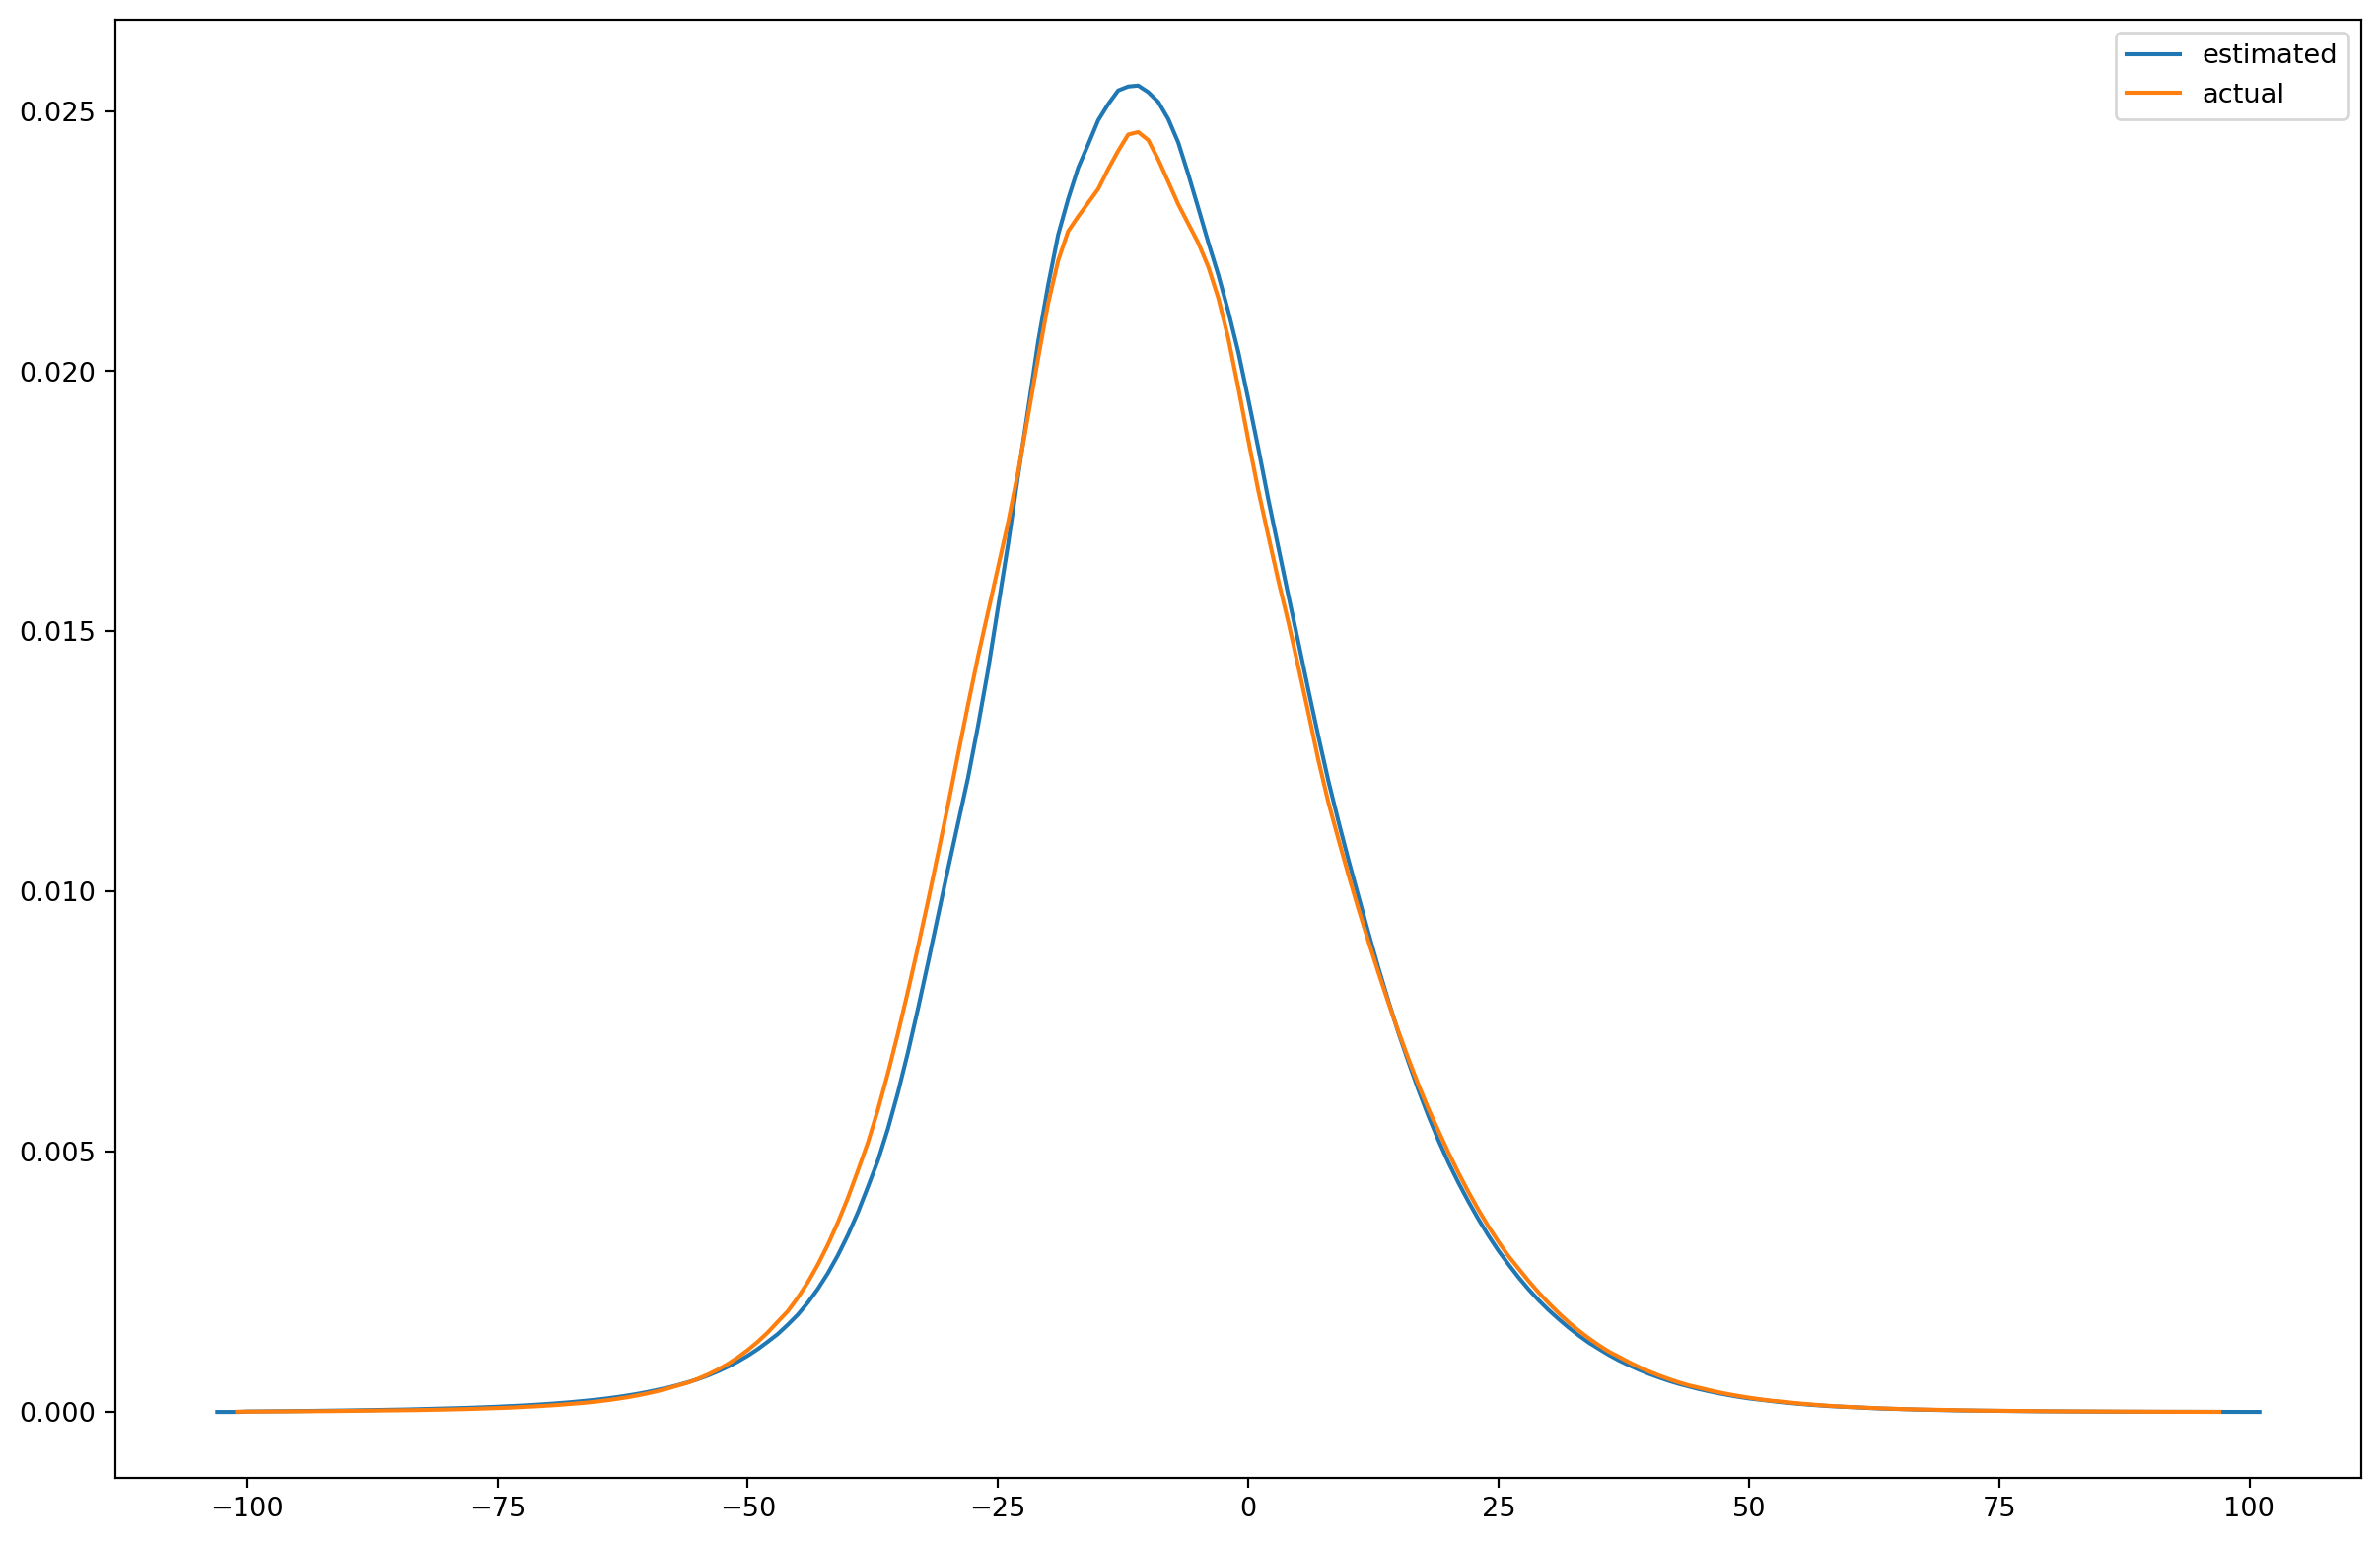

In [51]:
plt.plot(s3, label='estimated')
plt.plot(s0, label='actual')
plt.legend()

In [74]:
np.log(2)

0.6931471805599453

In [75]:
0.69**2

0.4760999999999999

In [76]:
2**2

4

In [77]:
np.sqrt(5)

2.23606797749979

In [101]:
6000 / 250

24.0